# Sanity Checks for Saliency Maps Simple CNN MNIST Example

true: 4, pred: 4
tensor([-28.8074,  -4.1995, -25.6185, -29.0302,  28.2435, -14.9452, -18.2997,
         -4.9662, -16.7132, -19.0259], grad_fn=<SelectBackward>)


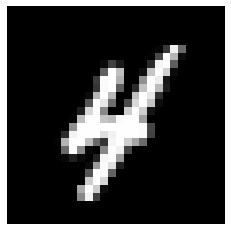

true: 8, pred: 8
tensor([-21.6865, -10.5112, -11.7300, -13.6257, -23.1770, -10.9294, -14.0151,
        -18.9519,  26.9457,  -6.3749], grad_fn=<SelectBackward>)


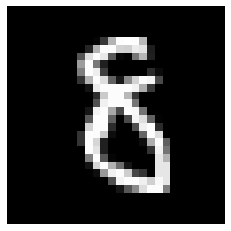

true: 4, pred: 4
tensor([-37.0494, -15.4232, -24.0901, -37.0792,  37.8260, -16.6117, -26.0817,
        -11.9274, -15.7291,   1.0369], grad_fn=<SelectBackward>)


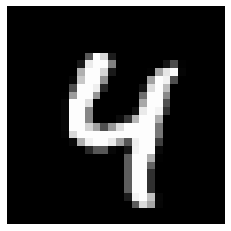

true: 9, pred: 9
tensor([-29.6795, -30.0848, -23.4497, -17.2592,   5.4393, -27.4469, -35.5971,
        -12.3468,  -0.5950,  36.8962], grad_fn=<SelectBackward>)


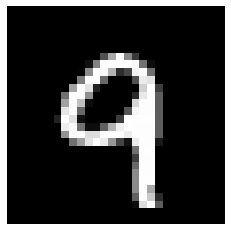

true: 4, pred: 4
tensor([-40.4492, -10.8241, -18.0372, -32.1956,  40.8904, -21.2721, -38.5731,
        -12.0040, -15.8174,  -2.7239], grad_fn=<SelectBackward>)


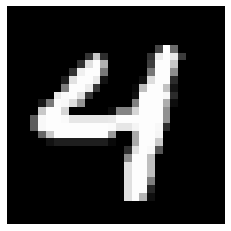

In [8]:
from torchvision import datasets, transforms
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from src import util
from captum.attr import IntegratedGradients, Saliency, InputXGradient, GuidedBackprop, DeepLift

# load pretrained model
model = torch.load('models/cnn_mnist.pt', map_location=torch.device('cpu'))
model.eval()

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

# load dataset
dataset = datasets.MNIST('data', train=False, transform=transform, download=True)
dataset_subset = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), 5, replace=False))
test_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=1, shuffle=False)

# print few examples
for image, label in test_loader:
    pred = model(image).argmax(axis=1)
    npimg = np.squeeze(np.squeeze(image.numpy()))
    plt.imshow(npimg, cmap='gray')
    print(f'true: {label[0]}, pred: {pred[0]}')
    plt.axis('off')
    plt.show()

In [2]:
# model architecture
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
)

In [3]:
# define module paths for cascading randomization
module_paths = [['linear2'], ['linear1'], ['conv2'], ['conv1']]

## Cascading Randomization: Specific Saliency Map

<ipython-input-4-3ef6a26ff9a6>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


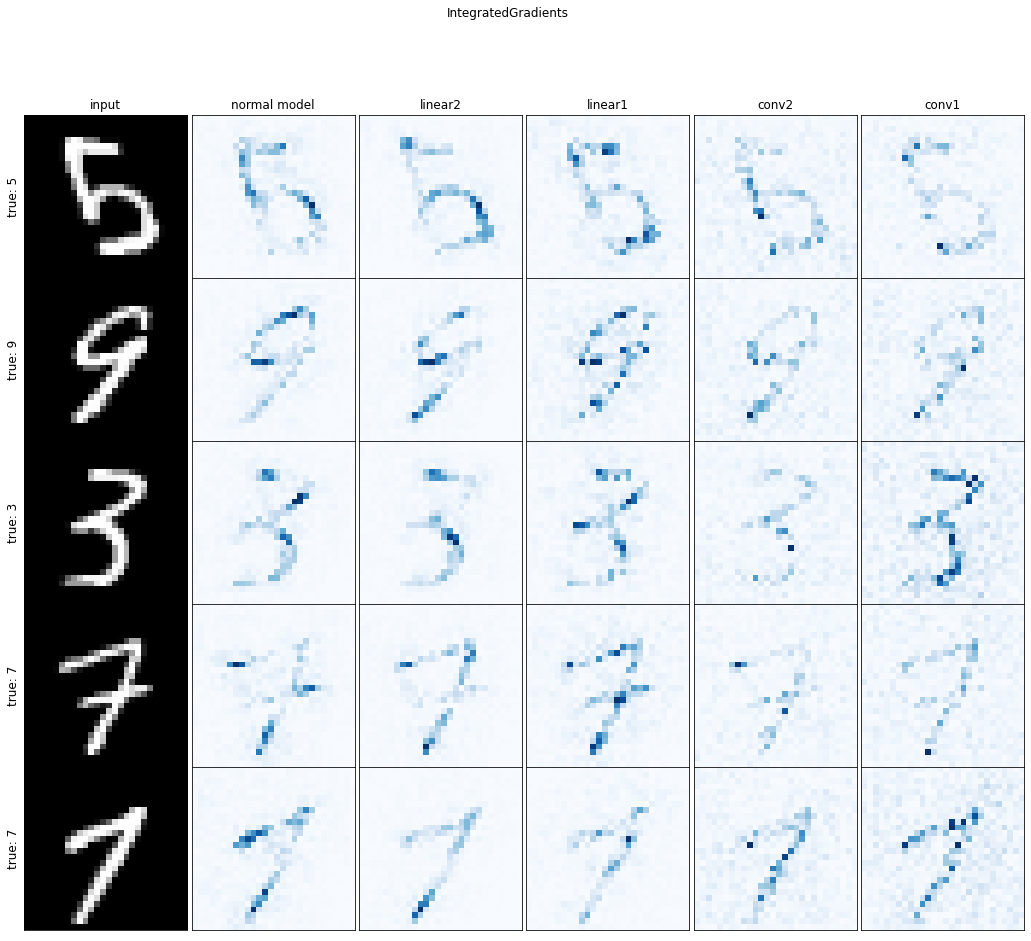

In [4]:
# visualize integrated gradients
fig, _ = util.visualize_cascading_randomization(model, module_paths, IntegratedGradients, test_loader)
fig.show()

<ipython-input-5-cd444a6271df>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


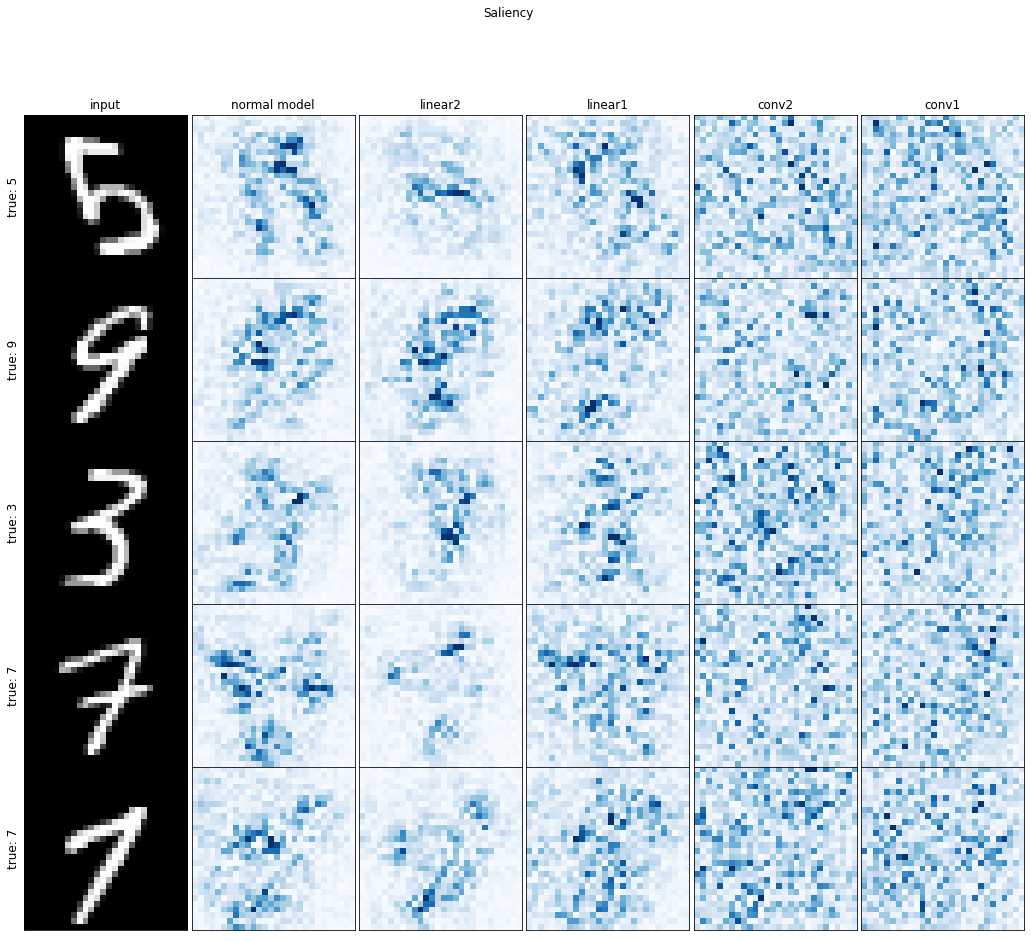

In [5]:
# visualize saliency (gradients)
fig, _ = util.visualize_cascading_randomization(model, module_paths, Saliency, test_loader)
fig.show()

<ipython-input-6-bf51c0159c41>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


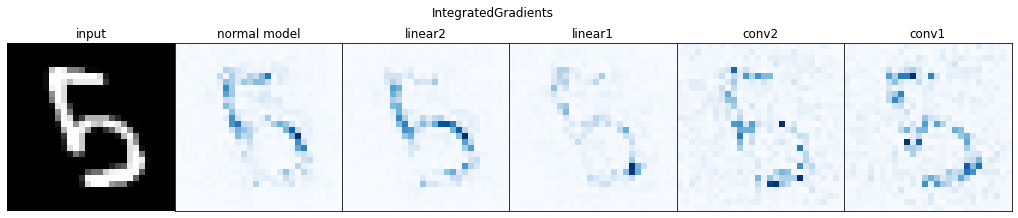

In [6]:
# single example case

for image, label in test_loader:
    fig, _ = util.visualize_cascading_randomization_single_example(model, module_paths, (image, label), IntegratedGradients)
    fig.show()
    break

### Cascading Randomization: Multiple Saliency Maps

/home/konrad/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
/home/konrad/miniconda3/envs/sanity_checks_pytorch/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
<ipython-input-7-406416d19b9f>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


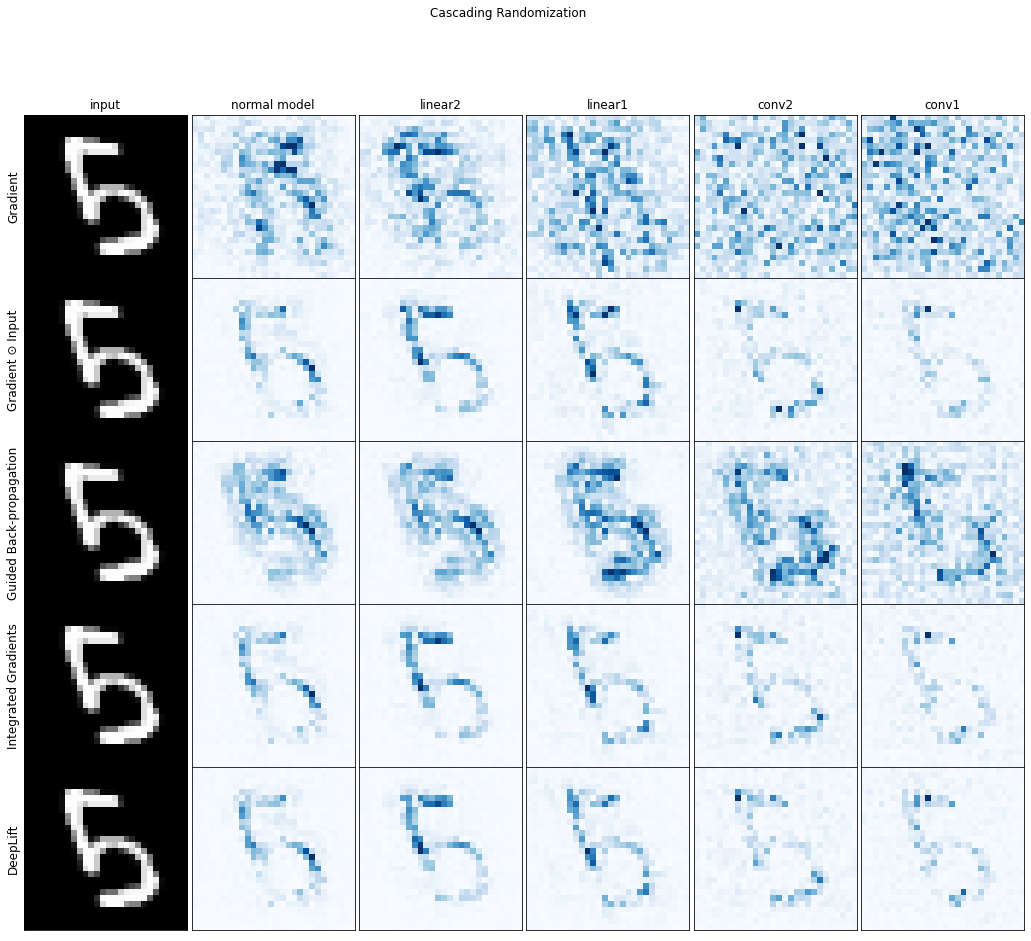

In [7]:
# multiple saliency maps for each example
for image, label in test_loader:
    fig, _ = util.visualize_cascading_randomization2(
        model,
        module_paths,
        (image, label),
        [Saliency, InputXGradient, GuidedBackprop, IntegratedGradients, DeepLift],
        ['Gradient', 'Gradient ⊙ Input', 'Guided Back-propagation', 'Integrated Gradients', 'DeepLift']
    )
    fig.show()
    break